In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup

In [2]:
train_df = pd.read_csv("data/twitter_data_train_multiclass.csv")
test_df = pd.read_csv("data/twitter_data_test_multiclass.csv")

print(train_df.shape)
print(test_df.shape)

(9446, 237)
(1667, 237)


### LSTM and RNN On Account's Description Text

In [11]:
train = train_df[['description_processed','tweets_list_processed', 'account_type_multi']]
test = test_df[['description_processed','tweets_list_processed','account_type_multi']]

train['description_processed'] = train['description_processed'].apply(str)
test['description_processed'] = test['description_processed'].apply(str)

C:\Users\radellng\AppData\Local\Temp\ipykernel_13156\1025729854.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['description_processed'] = train['description_processed'].apply(str)
C:\Users\radellng\AppData\Local\Temp\ipykernel_13156\1025729854.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['description_processed'] = test['description_processed'].apply(str)


In [4]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 128

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train['description_processed'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

tokenizer_test = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer_test.fit_on_texts(test['description_processed'].values)
word_index_test = tokenizer_test.word_index
print('Found %s unique tokens.' % len(word_index_test))

Found 16349 unique tokens.
Found 4366 unique tokens.


In [5]:
X = tokenizer.texts_to_sequences(train['description_processed'].values)
X_train = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train.shape)

x = tokenizer_test.texts_to_sequences(test['description_processed'].values)
X_test = pad_sequences(x, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test.shape)

Shape of data tensor: (9446, 250)
Shape of data tensor: (1667, 250)


In [6]:
y_train = to_categorical(train['account_type_multi'], num_classes=6)
y_test = to_categorical(test['account_type_multi'], num_classes=6)

print(y_train.shape)
print(y_test.shape)

(9446, 6)
(1667, 6)


In [7]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 128)          6400000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 6,449,798
Trainable params: 6,449,798
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
epochs = 10
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
133/133 [==============================] - 61s 444ms/step - loss: 1.2566 - accuracy: 0.4781 - val_loss: 1.0152 - val_accuracy: 0.5820
Epoch 2/10
133/133 [==============================] - 57s 430ms/step - loss: 0.9850 - accuracy: 0.6020 - val_loss: 0.9242 - val_accuracy: 0.6286
Epoch 3/10
133/133 [==============================] - 53s 400ms/step - loss: 0.8950 - accuracy: 0.6487 - val_loss: 0.8870 - val_accuracy: 0.6413
Epoch 4/10
133/133 [==============================] - 53s 402ms/step - loss: 0.8233 - accuracy: 0.6858 - val_loss: 0.8641 - val_accuracy: 0.6656
Epoch 5/10
133/133 [==============================] - 53s 399ms/step - loss: 0.7470 - accuracy: 0.7294 - val_loss: 0.8282 - val_accuracy: 0.6730
Epoch 6/10
133/133 [==============================] - 53s 398ms/step - loss: 0.6886 - accuracy: 0.7561 - val_loss: 0.8180 - val_accuracy: 0.6899
Epoch 7/10
133/133 [==============================] - 54s 409ms/step - loss: 0.6460 - accuracy: 0.7780 - val_loss: 0.8436 - val_ac

In [9]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

53/53 [==============================] - 2s 32ms/step - loss: 1.4923 - accuracy: 0.5465
Test set
  Loss: 1.492
  Accuracy: 0.546


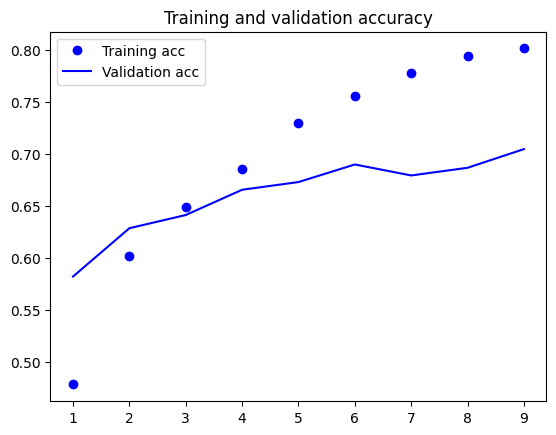

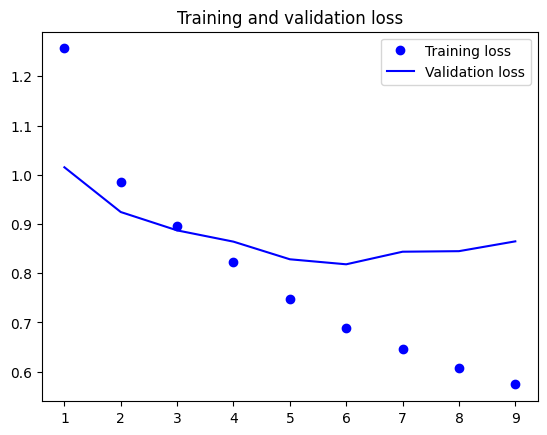

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### LSTM and RNN On Account's Tweets Text

In [12]:
train['tweets_list_processed'] = train['tweets_list_processed'].apply(str)
test['tweets_list_processed'] = test['tweets_list_processed'].apply(str)

tweet_tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tweet_tokenizer.fit_on_texts(train['tweets_list_processed'].values)
tweet_word_index = tweet_tokenizer.word_index
print('Found %s unique tokens.' % len(tweet_word_index))

tweet_tokenizer_test = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tweet_tokenizer_test.fit_on_texts(test['tweets_list_processed'].values)
tweet_word_index_test = tokenizer_test.word_index
print('Found %s unique tokens.' % len(tweet_word_index_test))


C:\Users\radellng\AppData\Local\Temp\ipykernel_13156\2769248041.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['tweets_list_processed'] = train['tweets_list_processed'].apply(str)
C:\Users\radellng\AppData\Local\Temp\ipykernel_13156\2769248041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['tweets_list_processed'] = test['tweets_list_processed'].apply(str)


Found 1290669 unique tokens.
Found 4366 unique tokens.


In [15]:
X_tweets = tweet_tokenizer.texts_to_sequences(train['tweets_list_processed'].values)
X_train_tweets = pad_sequences(X_tweets, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train_tweets.shape)

x_tweets = tweet_tokenizer_test.texts_to_sequences(test['tweets_list_processed'].values)
X_tweets_test = pad_sequences(x_tweets, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_tweets_test.shape)

Shape of data tensor: (9446, 250)
Shape of data tensor: (1667, 250)


In [16]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train_tweets.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
epochs = 10
batch_size = 64

history = model.fit(X_train_tweets, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 128)          6400000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 250, 128)         0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 6,449,798
Trainable params: 6,449,798
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
133/133 [==============================] - 54s 395ms/step - loss: 1.3102 - accuracy: 0.4245 - 

53/53 [==============================] - 2s 32ms/step - loss: 1.9918 - accuracy: 0.4325
Test set
  Loss: 1.992
  Accuracy: 0.433


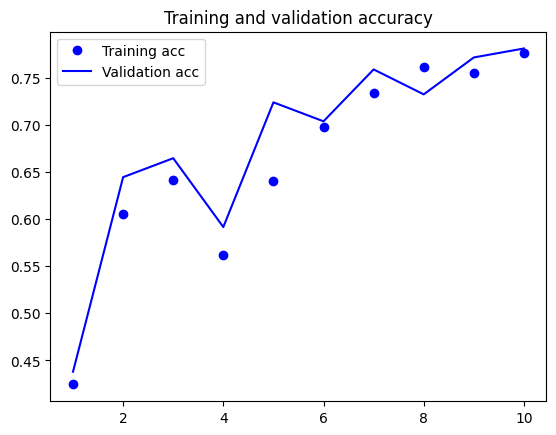

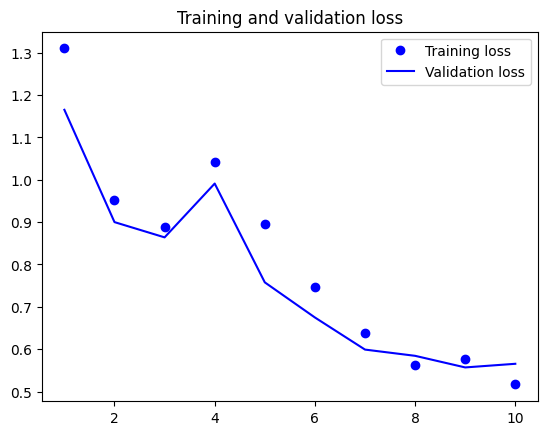

In [17]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()